In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
from scipy.signal import find_peaks
import os
from scipy import interpolate

In [20]:
def cpsdCal(directory_path1, directory_path2):
#     directory_path1= '.\\Data\\Data10_14\\600mV_44K_NDp3_step1\\'#690V_45K_ND0.1_step1\\'
#     print(directory_path)
    # if type(directory_path_dat1) is not type('String'):
    #     raise ValueError('Input Path must be a String')
#     print(directory_path+'FFT2.dat')
    LFN_spectrum = np.loadtxt(directory_path1+'FFT2.dat')#s33half    
    Coherence = np.loadtxt(directory_path1+'Coherence.dat')
    FFT1 = np.loadtxt(directory_path1+'FFT1.dat')
    V_L = np.loadtxt(directory_path1+'V_LTime2.dat')
    timeseries =np.loadtxt(directory_path1+'ampTime2.dat')
    shot_noise = np.loadtxt(directory_path1+'FFT2.dat') 
    cross_spectrom = np.loadtxt(directory_path1+'Cross_Spectrum.dat')#s13

    s33 = LFN_spectrum[1:,1]**2
    s23 = cross_spectrom[1:,1]
    s22 = FFT1[1:,1]**2
    lamb = s33/s23

#     directory_path3 = '.\\Data\\Data10_14\\600mV_41K_NDp3_step2\\'#690V_45K_ND0.1_step2\\'
    s12load = np.loadtxt(directory_path2+'Cross_Spectrum.dat')
    s11load = np.loadtxt(directory_path2+'FFT1.dat')
    s11 = s11load[1:,1]**2
    s12 = s12load[1:,1]
    f_vsqr = s23/lamb
    c1sqr = s12-f_vsqr
    c1 = np.sqrt(c1sqr)
    sn1sqr = s11-s12

    x = timeseries[:,0]
    y = timeseries[:,1]
    y_mins = y*-1 +50 #why are you adding 50

    peaks_max, _1 = find_peaks(y, height=0)
    peaks_min, _2 = find_peaks(y_mins, height=0)

    min_x = x[peaks_min]
    max_x = x[peaks_max]
    min_array = y[peaks_min]
    max_array = y[peaks_max]

    ave_min_1 = np.median(min_array)#why use median

    i_array = []
    for i in np.arange(len(min_array)):
        if min_array[i] > ave_min_1*1.05:
            i_array.append(i)
        else:
            pass

    min_array = np.delete(min_array,i_array)


    ave_max_1 = np.median(max_array)

    j_array = []
    for i in np.arange(len(max_array)):
        if max_array[i] < ave_max_1*.95:
            j_array.append(i)
        else:
            pass

    max_array = np.delete(max_array,j_array)

    max_array_average = np.average(max_array)
    min_array_average = np.average(min_array)
    V_L_ave = np.average(V_L[:,1])

    amp_final_4 = (max_array_average - min_array_average)/2.
    offset = (max_array_average+min_array_average)/2.

    del_phi = np.arccos((V_L_ave-offset)/amp_final_4)
    print(del_phi)
    tao = 2/4.0703e6 # (1/Hz) aka (s), this number comes from /home/qol/Google Drive/data/Torrey/Sub SQL Paper/Data/machzender_zeros_post_freespace_setup/

    dvdw = amp_final_4*np.sin(del_phi)*tao

    C = Coherence[1:,1]
    f = Coherence[1:,0]

    LFN_conversion = 0.01/(3e8/1064e-9) #L/(c/lambda) from Hz -> meters
    R = LFN_conversion/ (2*np.pi)/dvdw #dvdw is V -> hz, LFN_Conversion is hz - meters.
    M = np.sqrt((1-C)/C)*LFN_spectrum[1:,1]*R

    LFN = LFN_spectrum[1:,1]*R #dvdw is V -> hz, LFN_Conversion is hz - meters.
    M1 = LFN*np.sqrt((LFN**2/(C*LFN**2))-1)
    c1sqr_old = ((1-C)/C)*LFN**2 #Old M, not accounting for shot noise on PDF
    csqr_new = ((c1sqr_old/(1+sn1sqr/c1sqr)))
    M_new = np.sqrt(csqr_new[csqr_new>=0])
    f_new = f[csqr_new>=0]
    
    return M_new, M, f_vsqr, lamb, f, f_new, s12, s23, s11, s22, s33, c1


1.6167853348209542
1.6183272703225966


C:\Users\repag\Anaconda2\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in sqrt


Text(0.5, 1.0, '0.3 ND filter, 260mV, 42K, date 10/15')

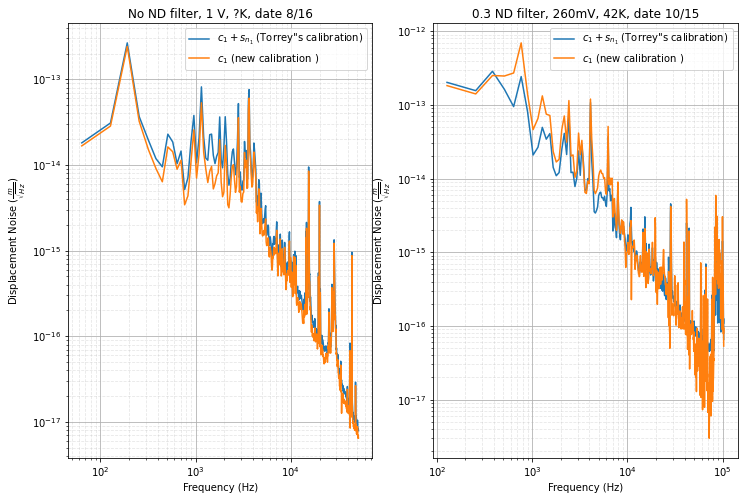

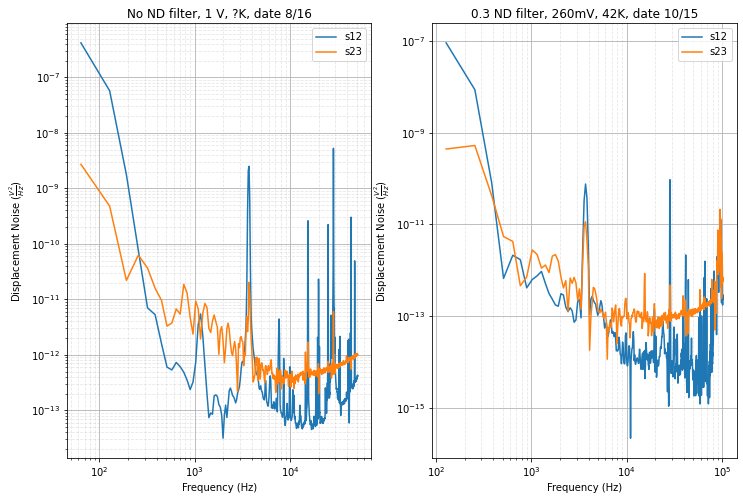

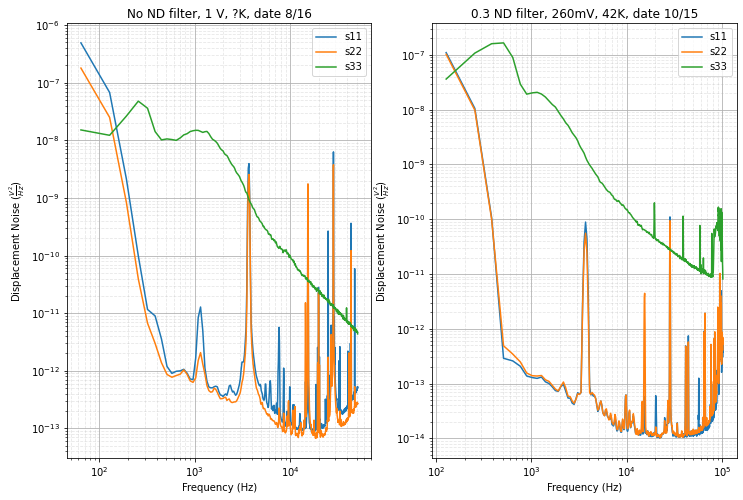

In [21]:
dir1_8_16 = '.\\Data\\Data8_16\\Step2_1V5050\\'
dir2_8_16 = '.\\Data\\Data8_16\\Step4_1V5050split\\'
M_new8, M8, f_vsqr8, lamb8, f8, f_new8, s128, s238, s118, s228, s338, c1sqr8 = cpsdCal(dir1_8_16,dir2_8_16)

dir1_10_15 = '.\\Data\\Data10_15\\260mv_42K_ndp3_step1\\'
dir2_10_15 = '.\\Data\\Data10_15\\260mv_45K_ndp3_step2_retry\\'
M_new15, M15, f_vsqr15, lamb15, f15, f_new15, s1215, s2315, s1115, s2215, s3315, c1sqr15 = cpsdCal(dir1_10_15,dir2_10_15)



fig1 = plt.figure(1,figsize=(12,8))
# plt.loglog(LFN_spectrum[1:,0],LFN_spectrum[1:,1])
ax11 = fig1.add_subplot(121)
ax11.grid()
ax11.grid(True)
ax11.minorticks_on()
ax11.set_xlabel('Frequency (Hz)')
ax11.set_ylabel('Displacement Noise ($\\frac{m}{\\sqrt{Hz}}$)')
ax11.grid(which='minor',linestyle='--',alpha = 0.3)
ax11.loglog(f8,M8,label = '$c_1+s_{n_1}$ (Torrey"s calibration)')
ax11.loglog(f_new8,M_new8,label='$c_1$ (new calibration )')
ax11.legend()
ax11.set_title('No ND filter, 1 V, ?K, date 8/16')

ax21 = fig1.add_subplot(122)
ax21.grid()
ax21.grid(True)
ax21.minorticks_on()
ax21.set_xlabel('Frequency (Hz)')
ax21.set_ylabel('Displacement Noise ($\\frac{m}{\\sqrt{Hz}}$)')
ax21.grid(which='minor',linestyle='--',alpha = 0.3)
ax21.loglog(f15,M15,label = '$c_1+s_{n_1}$ (Torrey"s calibration)')
ax21.loglog(f_new15,M_new15,label='$c_1$ (new calibration )')
ax21.legend()
ax21.set_title('0.3 ND filter, 260mV, 42K, date 10/15')

# from matplotlib.backends.backend_pdf import PdfPages
# pp = PdfPages('multipage_8_16and10_15.pdf')
# fig1.savefig('.\\Data\\Data10_15\\mfftdat.pdf')


fig3 = plt.figure(3,figsize=(12,8))
# plt.loglog(LFN_spectrum[1:,0],LFN_spectrum[1:,1])
ax13 = fig3.add_subplot(121)
ax13.grid()
ax13.grid(True)
ax13.minorticks_on()
ax13.set_xlabel('Frequency (Hz)')
ax13.set_ylabel('Displacement Noise ($\\frac{V^2}{{Hz}}$)')
ax13.grid(which='minor',linestyle='--',alpha = 0.3)
ax13.loglog(f8,s128,label='s12')
# ax13.loglog(f8,f_vsqr8,label='$F^2$')
ax13.loglog(f8,s238,label='s23')
# ax13.loglog(f8,s338,label='s33')
ax13.legend()
ax13.set_title('No ND filter, 1 V, ?K, date 8/16')

ax23 = fig3.add_subplot(122)
ax23.grid()
ax23.grid(True)
ax23.minorticks_on()
ax23.set_xlabel('Frequency (Hz)')
ax23.set_ylabel('Displacement Noise ($\\frac{V^2}{{Hz}}$)')
ax23.grid(which='minor',linestyle='--',alpha = 0.3)
ax23.loglog(f15, s1215, label='s12')
# ax23.loglog(f15, f_vsqr15, label='F^2')
ax23.loglog(f15, s2315, label='s23')
# ax23.loglog(f15, s3315, label='s33')
ax23.legend()
ax23.set_title('0.3 ND filter, 260mV, 42K, date 10/15')

# fig3.savefig('.\\Data\\Data10_15\\VltsCPSDdat.pdf')



fig4 = plt.figure(4,figsize=(12,8))
# plt.loglog(LFN_spectrum[1:,0],LFN_spectrum[1:,1])
ax14 = fig4.add_subplot(121)
ax14.grid()
ax14.grid(True)
ax14.minorticks_on()
ax14.set_xlabel('Frequency (Hz)')
ax14.set_ylabel('Displacement Noise ($\\frac{V^2}{{Hz}}$)')
ax14.grid(which='minor',linestyle='--',alpha = 0.3)
ax14.loglog(f8,s118,label='s11')
ax14.loglog(f8,s228,label='s22')
ax14.loglog(f8,s338,label='s33')
ax14.legend()
ax14.set_title('No ND filter, 1 V, ?K, date 8/16')

ax24 = fig4.add_subplot(122)
ax24.grid()
ax24.grid(True)
ax24.minorticks_on()
ax24.set_xlabel('Frequency (Hz)')
ax24.set_ylabel('Displacement Noise ($\\frac{V^2}{{Hz}}$)')
ax24.grid(which='minor',linestyle='--',alpha = 0.3)
ax24.loglog(f15, s1115, label='s11')
ax24.loglog(f15, s2215, label='s22')
ax24.loglog(f15, s3315, label='s33')
ax24.legend()
ax24.set_title('0.3 ND filter, 260mV, 42K, date 10/15')

# fig4.savefig('.\\Data\\Data10_15\\Vltsfftsqrdat.pdf')



# # plt.savefig('620mV_43K.pdf')




# plt.figure(3,figsize=(12,8))
# plt.grid()
# plt.grid(True)
# plt.grid(which='minor',linestyle='--',alpha = 0.3)
# plt.loglog(f8,s128,label='s12')
# plt.loglog(f8,f_vsqr8,label='F')
# plt.loglog(f8,s238,label='s23')
# plt.loglog(f8,s338,label='s33')
# # plt.loglog(f,c1sqr,label='c1')
# plt.legend()

# plt.figure(4,figsize=(12,8))
# plt.grid()
# plt.grid(True)
# plt.grid(which='minor',linestyle='--',alpha = 0.3)
# plt.loglog(f8,s118,label='s11')
# plt.loglog(f8,s228,label='s22')
# plt.loglog(f8,s338,label='s33')
# # plt.loglog(f,c1sqr,label='c1')
# plt.legend()

Text(0.5, 1.0, '0.3 ND filter, 260mV, 42K, date 10/15')

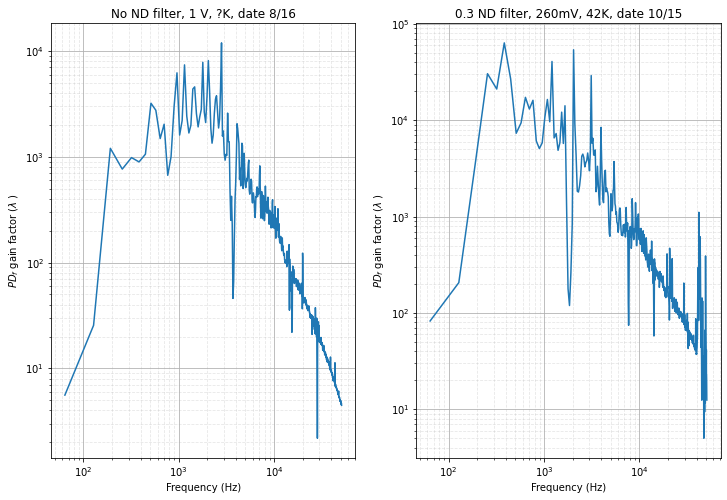

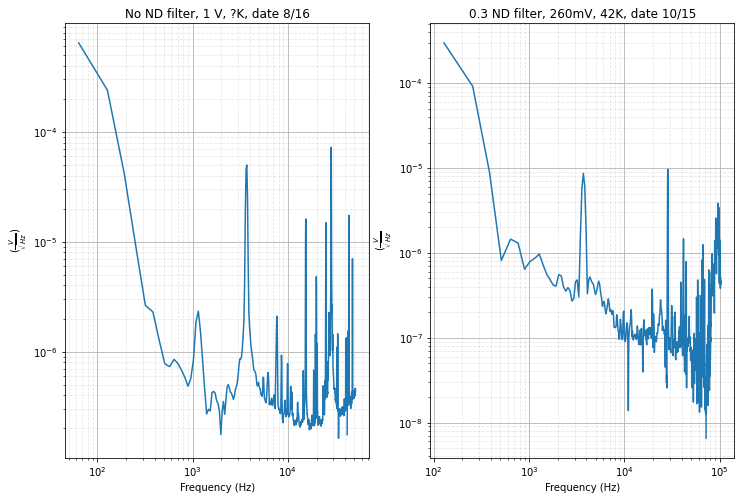

In [31]:
fig2 = plt.figure(2,figsize=(12,8))
# plt.loglog(LFN_spectrum[1:,0],LFN_spectrum[1:,1])
ax12 = fig2.add_subplot(121)
ax12.grid()
ax12.grid(True)
ax12.minorticks_on()
ax12.set_xlabel('Frequency (Hz)')
ax12.set_ylabel('$PD_f$ gain factor ($\lambda$ )')
ax12.grid(which='minor',linestyle='--',alpha = 0.3)
ax12.loglog(f8,lamb8)
# ax12.legend()
ax12.set_title('No ND filter, 1 V, ?K, date 8/16')

ax22 = fig2.add_subplot(122)
ax22.grid()
ax22.grid(True)
ax22.minorticks_on()
ax22.set_xlabel('Frequency (Hz)')
ax22.set_ylabel('$PD_f$ gain factor ($\lambda$ )')
ax22.grid(which='minor',linestyle='--',alpha = 0.3)
ax22.loglog(f8,lamb15)
# ax22.legend()
ax22.set_title('0.3 ND filter, 260mV, 42K, date 10/15')

# fig2.savefig('.\\Data\\Data10_15\\lamb1.pdf')

fig5 = plt.figure(5,figsize=(12,8))
# plt.loglog(LFN_spectrum[1:,0],LFN_spectrum[1:,1])
ax15 = fig5.add_subplot(121)
ax15.grid()
ax15.grid(True)
ax15.minorticks_on()
ax15.set_xlabel('Frequency (Hz)')
ax15.set_ylabel('($\\frac{V}{{\sqrt{Hz}}}$)')
ax15.grid(which='minor',linestyle='--',alpha = 0.3)
ax15.loglog(f8,c1sqr8)
# ax12.legend()
ax15.set_title('No ND filter, 1 V, ?K, date 8/16')

ax25 = fig5.add_subplot(122)
ax25.grid()
ax25.grid(True)
ax25.minorticks_on()
ax25.set_xlabel('Frequency (Hz)')
ax25.set_ylabel('($\\frac{V}{{\sqrt{Hz}}}$')
ax25.grid(which='minor',linestyle='--',alpha = 0.3)
ax25.loglog(f15,c1sqr15)
# ax22.legend()
ax25.set_title('0.3 ND filter, 260mV, 42K, date 10/15')

# fig5.savefig('.\\Data\\Data10_15\\C_1_vsqr.pdf')

In [ ]:
plt.figure()
plt.loglog(f

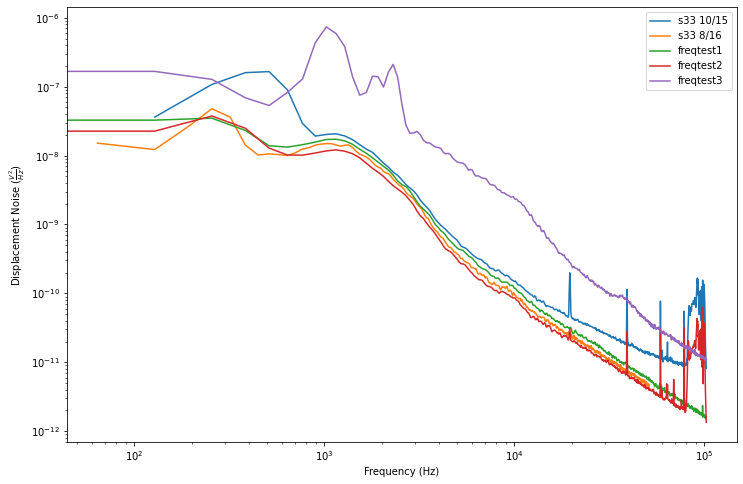

In [27]:
path10_20freq1 = '.\\Data\\Data10_21FreqNoise\\testnoise1\\'
LFN_spectrum = np.loadtxt(path10_20freq1+'FFT2.dat')
f21 = LFN_spectrum[:,0]
freqtest1 = LFN_spectrum[:,1]**2

path10_20freq2 = '.\\Data\\Data10_21FreqNoise\\testnoise2\\'
LFN_spectrum2 = np.loadtxt(path10_20freq2+'FFT2.dat')
freqtest2 = LFN_spectrum2[:,1]**2

path10_20freq3 = '.\\Data\\Data10_21FreqNoise\\testnoise3\\'
LFN_spectrum3 = np.loadtxt(path10_20freq3+'FFT2.dat')
freqtest3 = LFN_spectrum3[:,1]**2

plt.figure(5,figsize=(12,8))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Displacement Noise ($\\frac{V^2}{{Hz}}$)')
plt.loglog(f15, s3315, label='s33 10/15')
plt.loglog(f8, s338, label='s33 8/16')
plt.loglog(f21,freqtest1,label='freqtest1')
plt.loglog(f21,freqtest2,label='freqtest2')
plt.loglog(f21,freqtest3,label='freqtest3')
plt.legend()


In [ ]:
dir1 = '.\\Data10_15\\260mv_42K_ndp3_step1\\'
dir2 = '.\\Data10_15\\260mv_45K_ndp3_step2_retry\\'
M_new, M, f_vsqr, lamb, f, f_new, s12, s23, s11, s22, s33 = cpsdCal(dir1,dir2)

plt.figure(1,figsize=(12,8))
# plt.loglog(LFN_spectrum[1:,0],LFN_spectrum[1:,1])
plt.grid()
plt.grid(True)
plt.minorticks_on()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Displacement Noise ($\\frac{m}{\\sqrt{Hz}}$)')
plt.grid(which='minor',linestyle='--',alpha = 0.3)
plt.loglog(f,M,label = '$c_1+s_{n_1}$ (Torry"s calibration)')
plt.loglog(f_new,M_new,label='$c_1$ (new calibration )')
plt.legend()
plt.title('0.3 ND filter, 600mV, 44K')
# plt.savefig('620mV_43K.pdf')


# plt.figure(2,figsize=(12,8))
# # plt.loglog(LFN_spectrum[1:,0],LFN_spectrum[1:,1])
# plt.grid()
# plt.grid(True)
# plt.minorticks_on()
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('$PD_f$ gain factor ($\lambda$ )')
# plt.grid(which='minor',linestyle='--',alpha = 0.3)
# plt.loglog(f,lamb,label = 'c_1+s_{n_1}')
# # plt.loglog(f_new,M_new,label='c_1')

plt.figure(3,figsize=(12,8))
plt.grid()
plt.grid(True)
plt.grid(which='minor',linestyle='--',alpha = 0.3)
plt.loglog(f,s12,label='s12')
plt.loglog(f,f_vsqr,label='F')
plt.loglog(f,s23,label='s23')
plt.loglog(f,s33,label='s33')
# plt.loglog(f,c1sqr,label='c1')
plt.legend()

plt.figure(4,figsize=(12,8))
plt.grid()
plt.grid(True)
plt.grid(which='minor',linestyle='--',alpha = 0.3)
plt.loglog(f,s11,label='s11')
plt.loglog(f,s22,label='s22')
plt.loglog(f,s33,label='s33')
# plt.loglog(f,c1sqr,label='c1')
plt.legend()